In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Libraries

In [43]:
import sys
sys.path.append('../input/iterativestratification')

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.utils import to_categorical

#from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, MiniBatchKMeans, Birch, BisectingKMeans
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture


# Import data

In [44]:
#PATH_TRAIN = '/kaggle/input/icr-identify-age-related-conditions/train.csv'
#PATH_TEST = '/kaggle/input/icr-identify-age-related-conditions/test.csv'
PATH_TRAIN = 'train.csv'
PATH_TEST = 'test.csv'


train =  pd.read_csv(PATH_TRAIN).drop(columns='Id')
test = pd.read_csv(PATH_TEST).drop(columns='Id')
#test = pd.read_csv(PATH_TRAIN).drop(columns=['Id', 'Class'])

train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


# Explore data

In [45]:
print(f'[INFO] Shapes:'
      f'\n[+] train  -> {train.shape}'
      f'\n[+] test   -> {test.shape}\n')

print(f'[INFO] Any missing values:'
      f'\n[+] train  -> {train.isna().any().any()}'
      f'\n[+] test   -> {test.isna().any().any()}')

missing = train.isna().sum().reset_index()
missing.columns = ['columns', 'missing_count']

print(f'[INFO] Any missing values:'
      f'\n\n{missing[missing.missing_count > 0]}')

[INFO] Shapes:
[+] train  -> (617, 57)
[+] test   -> (5, 56)

[INFO] Any missing values:
[+] train  -> True
[+] test   -> False
[INFO] Any missing values:

   columns  missing_count
12      BQ             60
15      CB              2
16      CC              3
32      DU              1
40      EL             60
43      FC              1
47      FL              1
49      FS              2
55      GL              1


# Categorical data into float

In [46]:
column_train = train['EJ']
column_test = test['EJ']
print(f'Values in EJ train:\n{column_train.value_counts()}'
    f'\nValues in EJ test:\n{column_test.value_counts()}')

train['EJ'].replace({'A': 0.0, 'B': 1.0}, inplace=True)
test['EJ'].replace({'A': 0.0, 'B': 1.0}, inplace=True)

test.dtypes


Values in EJ train:
B    395
A    222
Name: EJ, dtype: int64
Values in EJ test:
A    5
Name: EJ, dtype: int64


AB     float64
AF     float64
AH     float64
AM     float64
AR     float64
AX     float64
AY     float64
AZ     float64
BC     float64
BD     float64
BN     float64
BP     float64
BQ     float64
BR     float64
BZ     float64
CB     float64
CC     float64
CD     float64
CF     float64
CH     float64
CL     float64
CR     float64
CS     float64
CU     float64
CW     float64
DA     float64
DE     float64
DF     float64
DH     float64
DI     float64
DL     float64
DN     float64
DU     float64
DV     float64
DY     float64
EB     float64
EE     float64
EG     float64
EH     float64
EJ     float64
EL     float64
EP     float64
EU     float64
FC     float64
FD     float64
FE     float64
FI     float64
FL     float64
FR     float64
FS     float64
GB     float64
GE     float64
GF     float64
GH     float64
GI     float64
GL     float64
dtype: object

# Impute missing values

In [47]:
imputer = KNNImputer(n_neighbors=10, weights='distance')
train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)

print(f'[INFO] Any missing values:'
    f'\n[+] train  -> {train.isna().any().any()}'
    f'\n[+] test  -> {test.isna().any().any()}')


[INFO] Any missing values:
[+] train  -> False
[+] test  -> False


# Split and normalize

In [48]:
#Split
X_train = train.drop('Class', axis=1)
y_train = train['Class']
X_test = test

#Normalize
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(f'[INFO] Shape:'
    f'\n[+] train  -> {X_train_scaled.shape}'
    f'\n[+] test  -> {X_test_scaled.shape}')

[INFO] Shape:
[+] train  -> (617, 56)
[+] test  -> (5, 56)


# Create clusters for X_train and assing to X_test

In [49]:
#Create clusters
def add_cluster_column(dataframe, n_clusters, clustering_method):
   
    if clustering_method == AffinityPropagation:
        clustering_model = clustering_method(damping=0.6)
    elif clustering_method == MeanShift:
        clustering_model = clustering_method()
    elif clustering_method == DBSCAN:
        clustering_model = clustering_method(eps=4.3, min_samples=3)
    elif clustering_method == OPTICS:
        clustering_model = clustering_method(min_samples=3)
    elif clustering_method == Birch:
        clustering_model = clustering_method(n_clusters=n_clusters, threshold=0.4)
    elif clustering_method == SpectralClustering:
        clustering_model = clustering_method(n_clusters=n_clusters, affinity='laplacian', assign_labels='discretize')
    else:
        clustering_model = clustering_method(n_clusters=n_clusters)

    #Fit and predict
    clusters = clustering_model.fit_predict(dataframe)

    column_name = clustering_method.__name__
    dframe = pd.DataFrame({column_name: clusters / clusters.max()})

    return dframe

In [50]:
clustering_methods = [KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, MiniBatchKMeans, Birch, BisectingKMeans]
reg_test = test.shape[0]

new_features_train = pd.DataFrame()
new_features_test = pd.DataFrame()

for clustering_method in clustering_methods:
    print(f'[INFO] {clustering_method.__name__}')
    
    df_clustered_train = add_cluster_column(X_train_scaled, 2, clustering_method)
    new_features_train = pd.concat([new_features_train, df_clustered_train], axis=1)

    #if reg_test > 20:
    #    df_clustered_test = add_cluster_column(X_test_scaled, 2, clustering_method)
    #else:
    df_clustered_test = pd.DataFrame({clustering_method.__name__: [np.nan] * reg_test})
       
    new_features_test = pd.concat([new_features_test, df_clustered_test], axis=1)

    


[INFO] KMeans
[INFO] AffinityPropagation
[INFO] MeanShift
[INFO] SpectralClustering
[INFO] AgglomerativeClustering
[INFO] DBSCAN
[INFO] OPTICS
[INFO] MiniBatchKMeans
[INFO] Birch
[INFO] BisectingKMeans


In [51]:
# Generate clusters arrangements of 4 conditions = 15
#kmeans = MiniBatchKMeans(n_clusters=10, random_state=10)
#kmeans = DBSCAN(eps=0.3, min_samples=10)
#kmeans.fit(X_train_scaled)

# Add featured cluster
#labels = kmeans.labels_
#labels_test = kmeans.predict(X_test_scaled)

from scipy.spatial.distance import cityblock


X_train_scaled = np.concatenate((X_train_scaled, new_features_train), axis=1)
X_test_scaled = np.concatenate([X_test_scaled, new_features_test], axis=1)

imputer = KNNImputer(n_neighbors=20, weights='distance')
imputer.fit(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)


print(f'[INFO] Shape before kmenas:'
    f'\n[+] train  -> {X_train_scaled.shape}'
    f'\n[+] test  -> {X_test_scaled.shape}')



[INFO] Shape before kmenas:
[+] train  -> (617, 66)
[+] test  -> (5, 66)


# Visualize new feature (clusters)

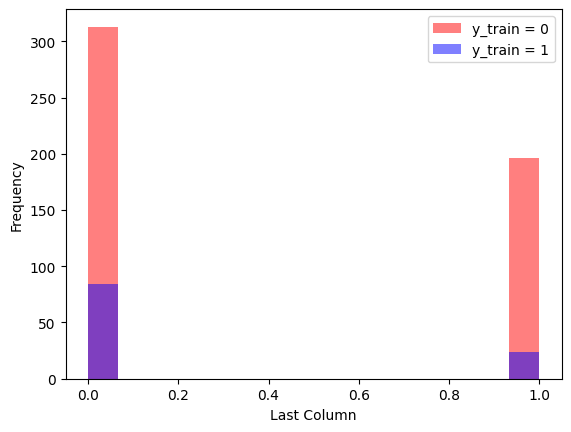

In [52]:
import matplotlib.pyplot as plt

last_column = X_train_scaled[:, -1]

plt.hist(last_column[y_train == 0], bins=15, color='red', alpha=0.5, label='y_train = 0')
plt.hist(last_column[y_train == 1], bins=15, color='blue', alpha=0.5, label='y_train = 1')

plt.xlabel('Last Column')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Some clusters are promising

# Create and train model

In [53]:
#Create model
input_dim = X_train_scaled.shape[1]

model = Sequential()
model.add(Dense(10, input_dim = input_dim, activation='relu'))
model.add(Dense(10, activation='tanh'))
#model.add(Dense(20, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

#Compile model
model.compile(loss=binary_crossentropy, optimizer='adam')

#Train model
model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, verbose=0)

# Make predictions and submit

In [54]:
y_pred = model.predict(X_test_scaled)

sub = pd.read_csv(PATH_TEST, usecols=['Id'])

sub['class_1'] = y_pred
sub['class_0'] = 1 - y_pred
sub.to_csv('submission.csv',index=False)
sub.head()

1/1 [==============================] - 0s 49ms/step


,Id,class_1,class_0
0,00eed32682bb,0.000863,0.999137
1,010ebe33f668,0.000863,0.999137
2,02fa521e1838,0.000863,0.999137
3,040e15f562a2,0.000863,0.999137
4,046e85c7cc7f,0.000863,0.999137
